# MIMIC-III data preprocessing 

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')

In [ ]:
data_dir = "/content/drive/MyDrive/Notebooks_MIMIC/data"

## Preprocessing ADMISSIONS.csv

In [ ]:
# SUBJECT_ID: unique identifier for each subject
# HADM_ID:    unique identifier for each hospitalization
# ADMITTIME:  admission date with format YYYY-MM-DD hh:mm:ss
# DISCHTIME:  discharge date with same format
# DEATHTIME:  death time (if it exists) with same format
# ADMISSION_TYPE: includes ELECTIVE, EMERGENCY, NEWBORN, URGENT
#
# see: https://mimic.mit.edu/docs/iii/tables/

df_adm = pd.read_csv(os.path.join(data_dir,"mimiciii_1.4","ADMISSIONS.csv"))

In [1]:
# <Hidden for privacy reasons>
#df_adm.head()

In [ ]:
# Convert to dates
df_adm.ADMITTIME = pd.to_datetime(df_adm.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_adm.DISCHTIME = pd.to_datetime(df_adm.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_adm.DEATHTIME = pd.to_datetime(df_adm.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

In [ ]:
# Remove NEWBORN admission type
df_adm = df_adm.loc[df_adm.ADMISSION_TYPE != 'NEWBORN']
# We are not modeling death events
df_adm = df_adm.loc[df_adm.DEATHTIME.isnull()]

In [ ]:
# Sort by subject_ID and admission date
df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])
df_adm = df_adm.reset_index(drop = True)

In [ ]:
# Get the next unplanned admission date, if it exists, for each SUBJECT_ID
df_adm['NEXT_ADMITTIME'] = df_adm.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
df_adm['NEXT_ADMISSION_TYPE'] = df_adm.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

In [2]:
# <Hidden for privacy reasons>
#df_adm.loc[df_adm["SUBJECT_ID"]==124]

In [ ]:
# we want to predict UNPLANNED re-admissions, so we should filter out the ELECTIVE next admissions.

# get rows where next admission is elective and replace with naT or nan
rows = df_adm.NEXT_ADMISSION_TYPE == 'ELECTIVE'
df_adm.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
df_adm.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN

In [3]:
# <Hidden for privacy reasons>
# df_adm.loc[df_adm["SUBJECT_ID"]==124]

In [ ]:
df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])
# Back fill
df_adm[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = df_adm.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')

In [4]:
# it didn't backfill for this subject, since the last row is NaN's
#df_adm.loc[df_adm["SUBJECT_ID"]==124]

In [ ]:
# days until the next admission
df_adm['DAYS_NEXT_ADMIT']=  (df_adm.NEXT_ADMITTIME - df_adm.DISCHTIME).dt.total_seconds()/(24*60*60)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3ef10962d0>]],
      dtype=object)

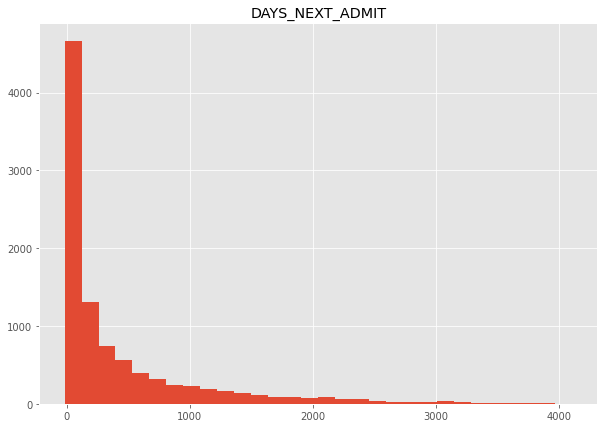

In [ ]:
plt.rcParams["figure.figsize"] = (10,7)
df_adm[['DAYS_NEXT_ADMIT']].hist(bins=30, grid=True)

## Processing NOTEEVENTS.csv

In [ ]:
# SUBJECT_ID: unique identifier for each subject
# HADM_ID:    unique identifier for each hospitalization
# CATEGORY:   includes ‘Discharge summary’, 
#                     ‘Echo’, 
#                     ‘ECG’, 
#                     ‘Nursing’, 
#                     ‘Physician ‘, 
#                     ‘Rehab Services’, 
#                     ‘Case Management ‘, 
#                     ‘Respiratory ‘, 
#                     ‘Nutrition’, 
#                     ‘General’, 
#                     ‘Social Work’, 
#                     ‘Pharmacy’, 
#                     ‘Consult’, 
#                     ‘Radiology’,
#                     ‘Nursing/other’
# TEXT:       clinical notes

# See: https://mimic.mit.edu/docs/iii/tables/

# There are multiple notes per hospitalization. 
# In the notes, the dates and PHI (name, doctor, location) have been converted for confidentiality. 
# There are also special characters such as \n (new line), numbers and punctuation.

df_notes = pd.read_csv(os.path.join(data_dir,"mimiciii_1.4","NOTEEVENTS.csv"))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df_notes.shape

(2083180, 11)

In [5]:
# <Hidden for privacy reasons>
#df_notes.head()

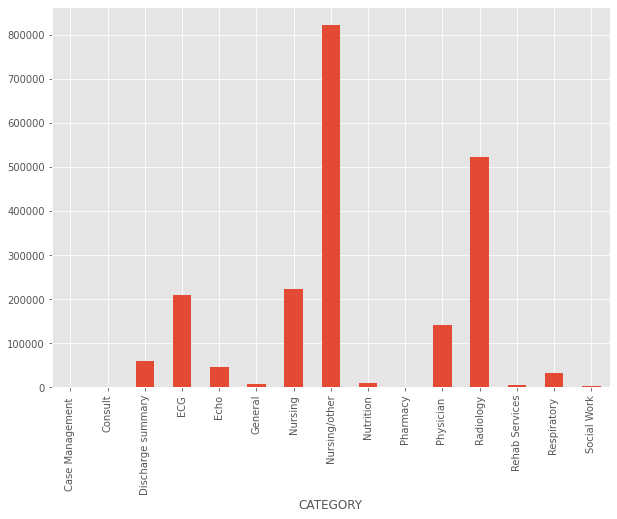

In [ ]:
# There are multiple notes per hospitalization. 
# In the notes, the dates and PHI (name, doctor, location) have been converted for confidentiality. 
# There are also special characters such as "\n", numbers and punctuation. 
df_notes.groupby("CATEGORY").size().plot.bar()

In [6]:
# <Hidden for privacy reasons>
#df_notes.TEXT.iloc[100]

In [ ]:
# For our proof of concept, let's use only discharge summary
df_notes_dis_sum = df_notes.loc[df_notes.CATEGORY == 'Discharge summary']
df_notes_dis_sum.shape

(59652, 11)

In [ ]:
#df_notes_dis_sum.groupby(['SUBJECT_ID','HADM_ID']).size().plot.bar()

In [ ]:
# There are cases with multiple discharge summries per admission
# use the last one
df_notes_dis_sum_last = (df_notes_dis_sum.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()
df_notes_dis_sum_last.shape

(52726, 11)

In [7]:
# <Hidden for privacy reasons>
#df_notes_dis_sum_last.head()

## Merge NOTEEVENTS and ADMISSIONS

In [ ]:
df_adm_notes = pd.merge(df_adm[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS_NEXT_ADMIT','NEXT_ADMITTIME','ADMISSION_TYPE','DEATHTIME']],
                        df_notes_dis_sum_last[['SUBJECT_ID','HADM_ID','TEXT']], 
                        on = ['SUBJECT_ID','HADM_ID'],
                        how = 'left')

In [ ]:
len(df_adm)

45321

In [ ]:
print('Fraction of missing notes:', df_adm_notes.TEXT.isnull().sum() / len(df_adm_notes))
print('Fraction notes with newlines:', df_adm_notes.TEXT.str.contains('\n').sum() / len(df_adm_notes))
print('Fraction notes with carriage returns:', df_adm_notes.TEXT.str.contains('\r').sum() / len(df_adm_notes))

Fraction of missing notes: 0.031795414929061586
Fraction notes with newlines: 0.9682045850709384
Fraction notes with carriage returns: 0.0


In [ ]:
df_adm["ADMISSION_TYPE"].unique()

array(['EMERGENCY', 'ELECTIVE', 'URGENT'], dtype=object)

In [ ]:
df_adm_notes.groupby('ADMISSION_TYPE').apply(lambda g: g.TEXT.isnull().sum())/df_adm_notes.groupby('ADMISSION_TYPE').size()

ADMISSION_TYPE
ELECTIVE     0.048076
EMERGENCY    0.028550
URGENT       0.028936
dtype: float64

# Add the label

In [ ]:
# We will try to predict if a patient is re-admitted in the next 30 days.
# therefore our new label: 
#       1 - readmitted
#       0 - not readmitted

df_adm_notes['OUTPUT_LABEL'] = (df_adm_notes.DAYS_NEXT_ADMIT < 30).astype('int')

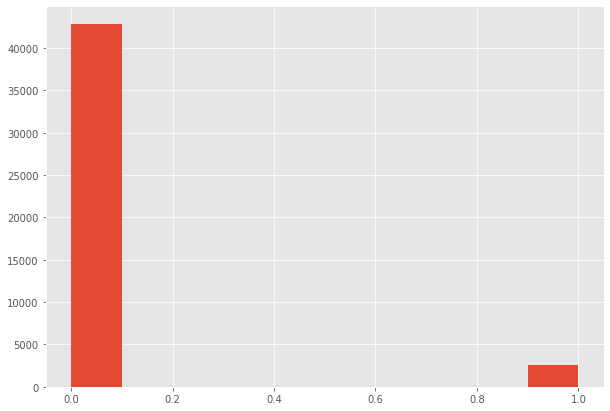

In [ ]:
# The classes are imbalanced
df_adm_notes['OUTPUT_LABEL'].hist()

In [ ]:
print('Number of positive samples:', (df_adm_notes.OUTPUT_LABEL == 1).sum())
print('Number of negative samples:',  (df_adm_notes.OUTPUT_LABEL == 0).sum())
print('Total samples:', len(df_adm_notes))

Number of positive samples: 2549
Number of negative samples: 42772
Total samples: 45321


In [8]:
# <Hidden for privacy reasons>
# df_adm_notes.head()

## Save 

In [ ]:
#df_adm_notes[["TEXT","OUTPUT_LABEL"]].to_csv(os.path.join(data_dir,"preproc","admiss_notes.csv"), index=False)

In [ ]:
df_adm.shape

(45321, 22)

In [ ]:
# Modify the original dataframe by dealing with the missing text, newlines and carriage returns
def preprocess_text(df):
    df.TEXT = df.TEXT.fillna(' ')
    df.TEXT =df.TEXT.str.replace('\n',' ')
    df.TEXT =df.TEXT.str.replace('\r',' ')
    return df

In [ ]:
df_adm_notes = preprocess_text(df_adm_notes)

In [ ]:
df_adm_notes[["TEXT","OUTPUT_LABEL"]].to_csv(os.path.join(data_dir,"preproc","admiss_notes.csv"), index=False)